In [1]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from functions import *
from ffnn import *
import os
import pathlib
from random import random, seed
from IPython import embed
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from functions import *
from ffnn import *
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from pandas.plotting import table
from sklearn.metrics import roc_curve, auc

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )




## Read the saved data from the runs

In [2]:
# set seed to get same random numbers
seed(42)

# load, scale and split original data
cancer = load_breast_cancer()
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)
X = cancer.data
target = cancer.target
target = target.reshape(target.shape[0], 1)
X_train, X_val, t_train, t_val = train_test_split(X, target, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

## Read the saved results table
results = pd.read_csv('result_updated_momentum_seed42.csv')#, index_col=[ 12])
#results = pd.read_csv('res_arch1_2_3_all.csv')#, index_col=[ 12])
#results['Momentum'] = 0.3

# Manupulate the Momentum column to remove the nans
r1 = results[results['Scheduler'].isin(['Adam','RMS_prop','Adagrad','Constant'])].copy()
r2 = results[results['Scheduler'].isin(['Momentum','AdagradMomentum'])].copy()
r2.dropna(subset='Momentum', inplace=True)
r = pd.concat([r1,r2]) 
r.reset_index(drop=True,inplace=True)

# Select the best runs
#res=results.sort_values(['Test accuracy'],ascending=False).groupby(['Architecture', 'Hidden function', 'Scheduler']).head(1)
res=r.sort_values(['Test accuracy'],ascending=False).groupby(['Architecture', 'Hidden function', 'Scheduler']).head(1)

# Options to make printable table, commented since it changes the res file
# res.rename(columns={"Eta": ' Eta '})
# res['Test accuracy'] = res['Test accuracy'].map(lambda x: '{0:.3}'.format(x))
# res['Train accuracy'] = res['Train accuracy'].map(lambda x: '{0:.3}'.format(x))
# res['Eta'] = res['Eta'].map(lambda x: '{0:.1e}'.format(x))
# res['Lambda'] = res['Lambda'].map(lambda x: '{0:.1e}'.format(x))

#pd.set_option('expand_frame_repr', False)
#statistics = cancerpd.describe()
#table = pretty_print(statistics)
table = pretty_print(res)


## Plot cancer data

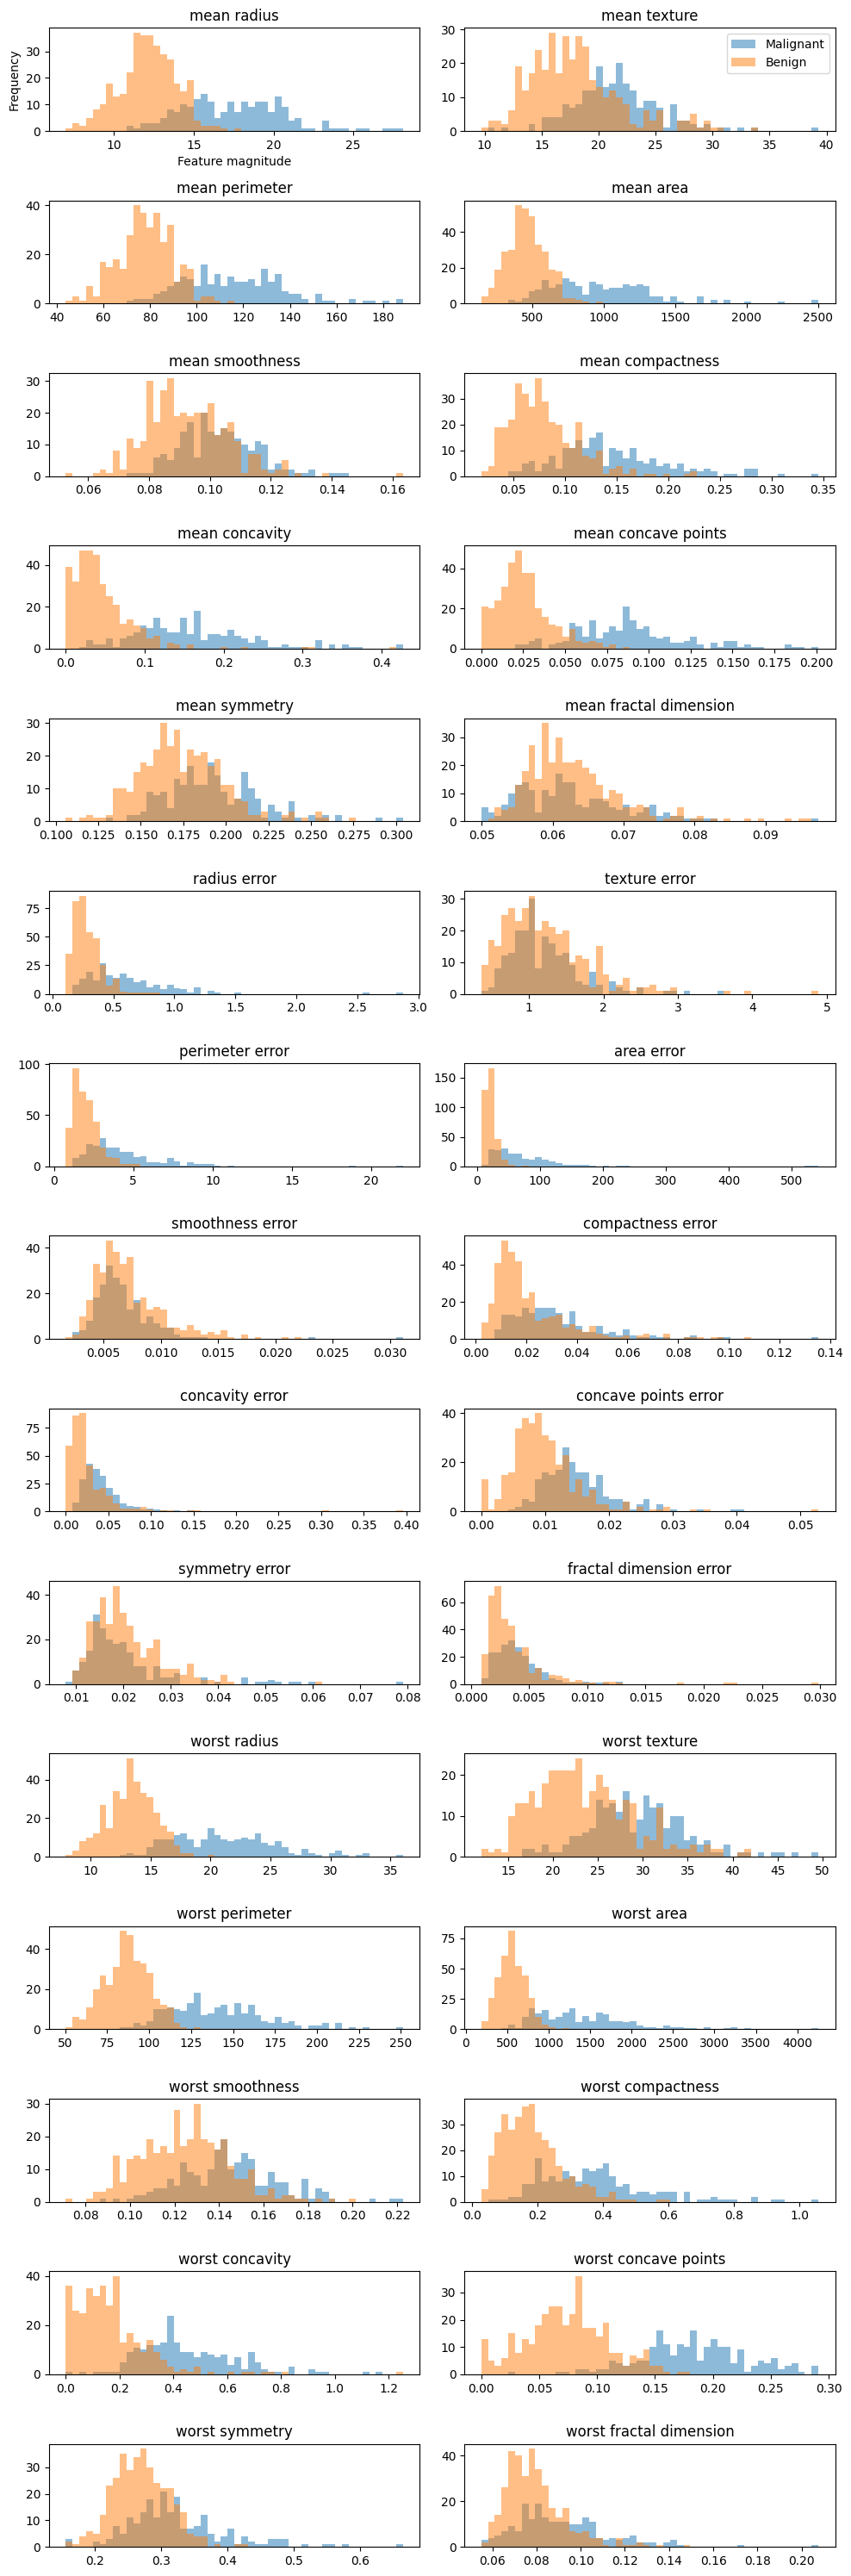

In [3]:
fig, axes = plt.subplots(15,2,figsize=(10,30))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:,i], bins =50)
    ax[i].hist(malignant[:,i], bins = bins, alpha = 0.5)
    ax[i].hist(benign[:,i], bins = bins, alpha = 0.5)
    ax[i].set_title(cancer.feature_names[i])
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[1].legend(["Malignant", "Benign"], loc ="best")
fig.tight_layout()
plt.show()

## Correlation cancer data

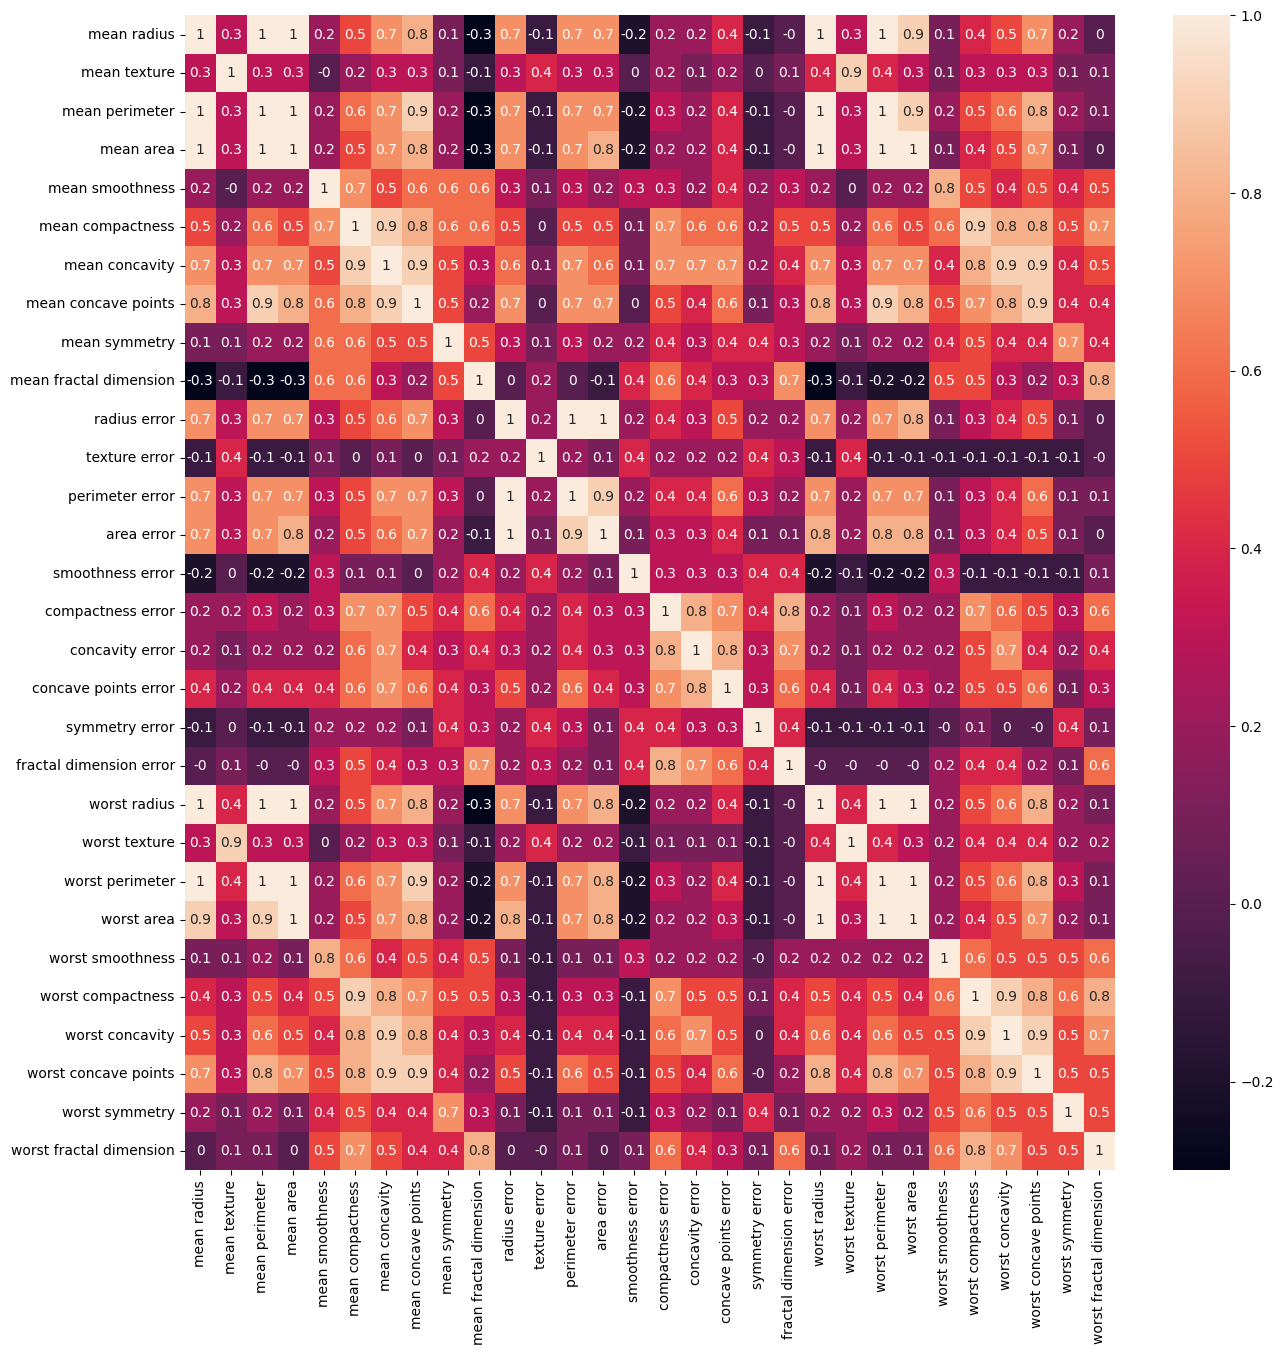

In [4]:
correlation_matrix = cancerpd.corr().round(1)
plt.figure(figsize=(15,15))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

## Best results for architecture

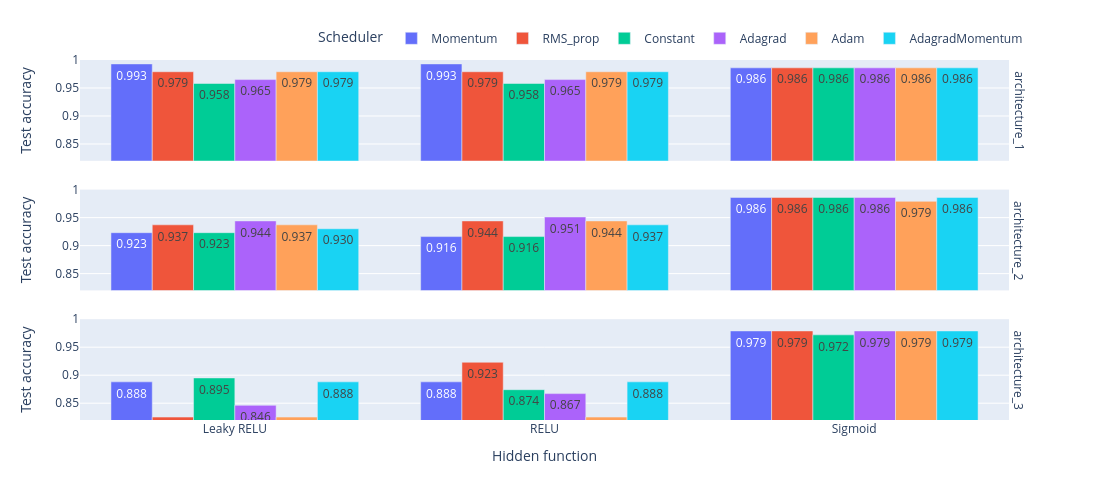

In [5]:
# Nice px.bar from plotly (good the df)
fig1 = px.bar(res, x='Hidden function', y='Test accuracy', 
             color='Scheduler',
             facet_row='Architecture',
             facet_row_spacing=0.08,
             barmode="group",
             text_auto='.3f',
             width=600, height=500)
fig1.update_yaxes({'range': (0.82,1)})
# Plotly trick to move legend position
fig1.update_layout(legend=dict(orientation="h",yanchor="bottom",
                              y=1.02,xanchor="right", x=1 ))
# More plotly trick for architecture labels
fig1.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
#fig1.show()
# Write image to png
#fig1.write_image(file='Test_accuracy_best_res.png', format='png', 
#                scale=4, width=600, height=500, engine='auto')

## Parameter space / best combinations 

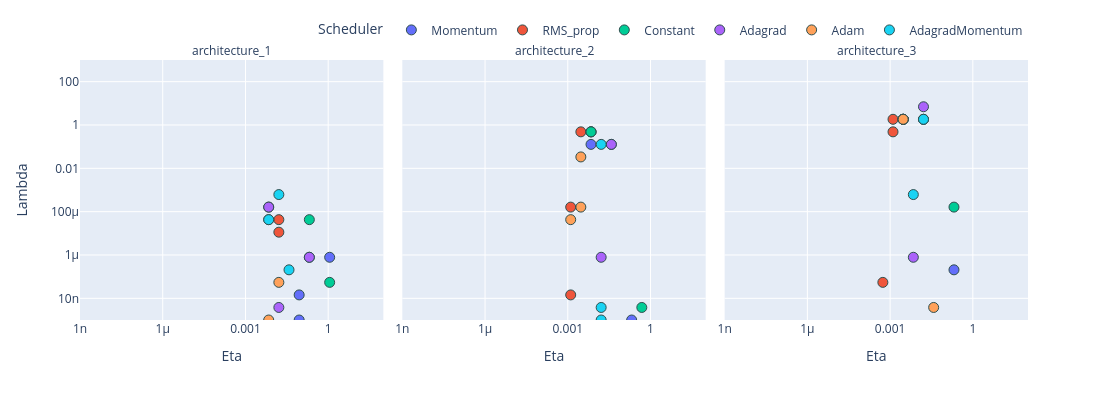

In [6]:
# Check for hidden function best performers plot on the Eta/Lambda parameter space
fig2 = px.scatter(res, x='Eta', y='Lambda', 
                color='Scheduler',
                # symbol='Hidden function',
                facet_col='Architecture',
                log_x=True,
                log_y=True,
                width=800, height=400)
fig2.update_traces(marker=dict(size=10,line=dict(width=1,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'),
                      textposition='top center')
fig2.update_traces(textposition='top center')
# Plotly trick to move legend position
fig2.update_layout(legend=dict(orientation="h",yanchor="bottom",
                              y=1.06,xanchor="right", x=1 ))
# More plotly trick for architecture labels
fig2.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# tested parameter space
fig2.update_xaxes(range=[np.log10(1e-9), np.log10(1e2) ]) 
fig2.update_yaxes(range=[np.log10(1e-9), np.log10(1e3) ])
fig2.show()
# Write image to png
#fig2.write_image(file='Lambda_Eta_best_res.png', format='png', 
#                scale=4, width=800, height=400, engine='auto')

## Plot scores curves

In [7]:
seed(42)

# Get the 5 best model for plotting
res_short = res.head(5).copy()

# initialise new columns
res_short['val_accs'] = ''
res_short['train_accs'] = ''

# hyperparamters
epochs = 10
batches = 5
input_nodes = X_train.shape[1]
output_nodes = 1

# Define dimensions
architecture_dict = {'architecture_1':(input_nodes,100,output_nodes),
              'architecture_2':(input_nodes,50,50,50,output_nodes),
              'architecture_3':(input_nodes,101,101,101,output_nodes)
              }
# Define hidden functions
hidden_func_dict = {'Sigmoid':sigmoid,
              'RELU':RELU,
              'Leaky RELU':LRELU
              }
# Define scheduler
scheduler_dict = {
            'Constant': Constant, 
            'Adagrad': Adagrad,
            'RMS_prop': RMS_prop,
            'Adam': Adam, 
            'Momentum': Momentum, 
            'AdagradMomentum':AdagradMomentum 
            }

for index, row in res_short.iterrows():
    architecture = architecture_dict[res_short.loc[index, 'Architecture']]
    hidden_func = hidden_func_dict[res_short.loc[index, 'Hidden function']]
    lmbd = res_short.loc[index, 'Lambda']
    eta = res_short.loc[index, 'Eta']
    momentum = res_short.loc[index, 'Momentum']
    neural_network = FFNN(dimensions=architecture, 
                          hidden_func=hidden_func, 
                          output_func=sigmoid, 
                          cost_func=CostLogReg, 
                          seed=2023)
    neural_network.reset_weights()
    
    scheduler_func = scheduler_dict[row['Scheduler']]
    match scheduler_func.__name__:
        case 'Constant': scheduler = scheduler_func(eta=eta)
        case 'Adagrad': scheduler = scheduler_func(eta=eta)
        case 'RMS_prop': scheduler = scheduler_func(eta=eta, rho=0.9)
        case 'Adam': scheduler = scheduler_func(eta=eta, rho=0.9, rho2=0.999)
        case 'Momentum': scheduler = scheduler_func(eta=eta, momentum = momentum)
        case 'AdagradMomentum': scheduler = scheduler_func(eta=eta, momentum = momentum)

    try:
        scores = neural_network.fit(X_train, t_train, scheduler, 
                                        epochs=epochs, batches=batches, 
                                        X_val=X_val, t_val=t_val, lam=lmbd)
        # update with test and train accuracy 
        res_short.at[index,'val_accs']=scores['val_accs']
        res_short.at[index,'train_accs']=scores['train_accs']
    except:
        continue

Momentum: Eta=0.0885866790410082, Lambda=1.4384498882876632e-08
  [=======================================>] 100.0% | train_error: 0.389 | train_acc: 0.981 | val_error: 0.145 | val_acc: 0.993 Momentum: Eta=0.0885866790410082, Lambda=9.999999999999999e-10
  [=======================================>] 100.0% | train_error: 0.389 | train_acc: 0.981 | val_error: 0.145 | val_acc: 0.993 RMS_prop: Eta=0.0012742749857031, Lambda=1.4384498882876632e-08
  [=======================================>] 100.0% | train_error: 0.292 | train_acc: 0.986 | val_error: 0.725 | val_acc: 0.965 Constant: Eta=1.1288378916846884, Lambda=5.4555947811685146e-08
  [=======================================>] 100.0% | train_error: 0.243 | train_acc: 0.988 | val_error: 0.435 | val_acc: 0.979 Adagrad: Eta=0.0162377673918872, Lambda=7.847599703514623e-07
  [=======================================>] 100.0% | train_error: 0.341 | train_acc: 0.984 | val_error: 1.01 | val_acc: 0.951  

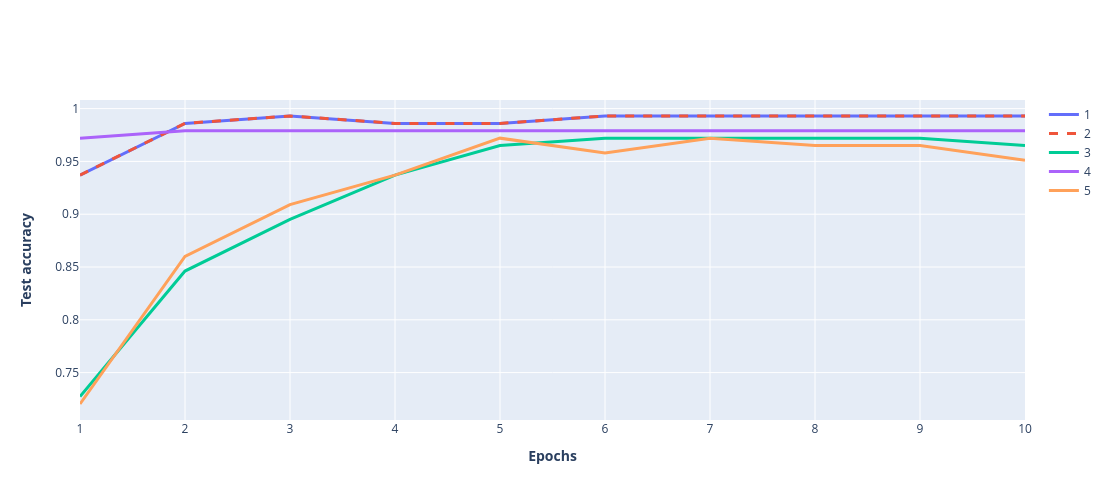

<Figure size 640x480 with 0 Axes>

In [8]:
# plotting different epoch curves with plotly interaction on hover
fig1 = plt.figure()
fig_title = 'Convergence train'
x_epochs = 1 + np.arange(epochs)
fig = go.Figure()
ifig=0
styles=['solid','dash','solid','solid','solid']
for index, row in res_short.iterrows():
    if len(row['val_accs'])>0:
        ifig+=1
        fig.add_trace(go.Scatter(x=x_epochs,
                             y = row['val_accs'],
                             mode ='lines',
                             name = ifig,
                             line=dict(width=3, dash=styles[ifig-1])
                            ))

# tested parameter space
fig.update_xaxes(title='<b>Epochs<b>') 
fig.update_yaxes(title='<b>Test accuracy<b>')
fig.update_layout(width=600, height=500)
fig.show()

## Get predicted values from best run

In [9]:
seed(42)

# Make pd dataframe of the best model 
res_best = res.head(1).copy()

# initialise new columns
res_best['val_accs'] = ''
res_best['train_accs'] = ''

# hyperparamters
epochs = 10
batches = 5
input_nodes = X_train.shape[1]
output_nodes = 1

# Define dimensions
architecture_dict = {'architecture_1':(input_nodes,100,output_nodes),
              'architecture_2':(input_nodes,50,50,50,output_nodes),
              'architecture_3':(input_nodes,101,101,101,output_nodes)
              }
# Define hidden functions
hidden_func_dict = {'Sigmoid':sigmoid,
              'RELU':RELU,
              'Leaky RELU':LRELU
              }
# Define scheduler
scheduler_dict = {
            'Constant': Constant, 
            'Adagrad': Adagrad,
            'RMS_prop': RMS_prop,
            'Adam': Adam, 
            'Momentum': Momentum, 
            'AdagradMomentum':AdagradMomentum 
            }
# Loop not necessary since only one value, but easier to reuse old loop
for index, row in res_best.iterrows():
    architecture = architecture_dict[res_best.loc[index, 'Architecture']]
    hidden_func = hidden_func_dict[res_best.loc[index, 'Hidden function']]
    lmbd = res_best.loc[index, 'Lambda']
    eta = res_best.loc[index, 'Eta']
    momentum = res_best.loc[index, 'Momentum']
    neural_network = FFNN(dimensions=architecture, 
                          hidden_func=hidden_func, 
                          output_func=sigmoid, 
                          cost_func=CostLogReg, 
                          seed=2023)
    neural_network.reset_weights()
    
    scheduler_func = scheduler_dict[row['Scheduler']]
    match scheduler_func.__name__:
        case 'Constant': scheduler = scheduler_func(eta=eta)
        case 'Adagrad': scheduler = scheduler_func(eta=eta)
        case 'RMS_prop': scheduler = scheduler_func(eta=eta, rho=0.9)
        case 'Adam': scheduler = scheduler_func(eta=eta, rho=0.9, rho2=0.999)
        case 'Momentum': scheduler = scheduler_func(eta=eta, momentum = momentum)
        case 'AdagradMomentum': scheduler = scheduler_func(eta=eta, momentum = momentum)

    scores = neural_network.fit(X_train, t_train, scheduler, 
                                        epochs=epochs, batches=batches, 
                                        X_val=X_val, t_val=t_val, lam=lmbd)

# Make predictions for plot under
y_pred_ffnn = neural_network.predict(X_val)
y_pred_ffnn_train = neural_network.predict(X_train)
accuracy_ffnn_train = scores['train_accs'][-1]
accuracy_ffnn_test = scores['val_accs'][-1]


Momentum: Eta=0.0885866790410082, Lambda=1.4384498882876632e-08
  [=======================================>] 100.0% | train_error: 0.389 | train_acc: 0.981 | val_error: 0.145 | val_acc: 0.993 

## Logistic regression

In [10]:
# logistic regression scikit
t_train_scikit = np.ravel(t_train)
t_val_scikit = np.ravel(t_val)

# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, t_train_scikit)
y_log_scikit = logreg.predict_proba(X_val)
y_log_scikit = np.argmax(y_log_scikit, axis=1)
fpr_log, tpr_log, thresholds = metrics.roc_curve(t_val_scikit, y_log_scikit) # false positive rates, true positive rates
roc_auc_log = auc(fpr_log, tpr_log) # area under curve
accuracy_scikit = accuracy_score(t_val_scikit, y_log_scikit)
print(accuracy_scikit)

0.9790209790209791


Constant: Eta=9.999999999999999e-05, Lambda=9.999999999999999e-06
  [=======================================>] 100.0% | train_error: 8.61 | train_acc: 0.585 | val_error: 11.3 | val_acc: 0.455 Constant: Eta=9.999999999999999e-05, Lambda=2.7825594022071256e-05
  [=======================================>] 100.0% | train_error: 8.61 | train_acc: 0.585 | val_error: 11.3 | val_acc: 0.455 Constant: Eta=9.999999999999999e-05, Lambda=7.742636826811277e-05
  [=======================================>] 100.0% | train_error: 8.61 | train_acc: 0.585 | val_error: 11.3 | val_acc: 0.455 Constant: Eta=9.999999999999999e-05, Lambda=0.00021544346900318823
  [=======================================>] 100.0% | train_error: 8.61 | train_acc: 0.585 | val_error: 11.3 | val_acc: 0.455 Constant: Eta=9.999999999999999e-05, Lambda=0.0005994842503189409
  [=======================================>] 100.0% | train_error: 8.61 | train_acc: 0.585 | val_error: 11.3 | val_acc: 0.455 Constant: Eta=9.999999999999999e-05, L

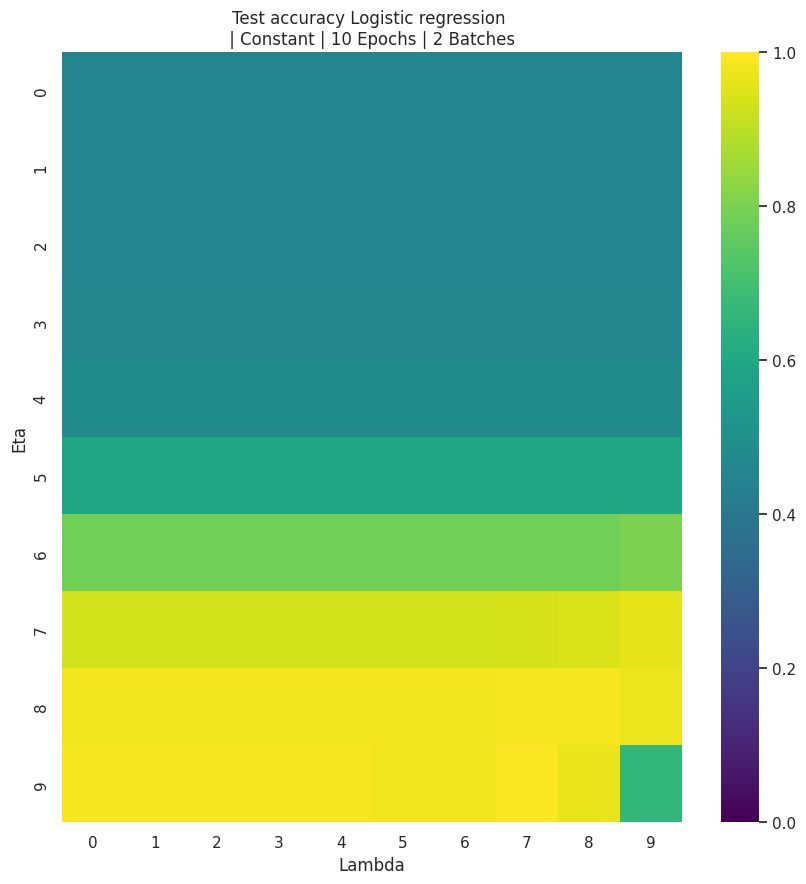

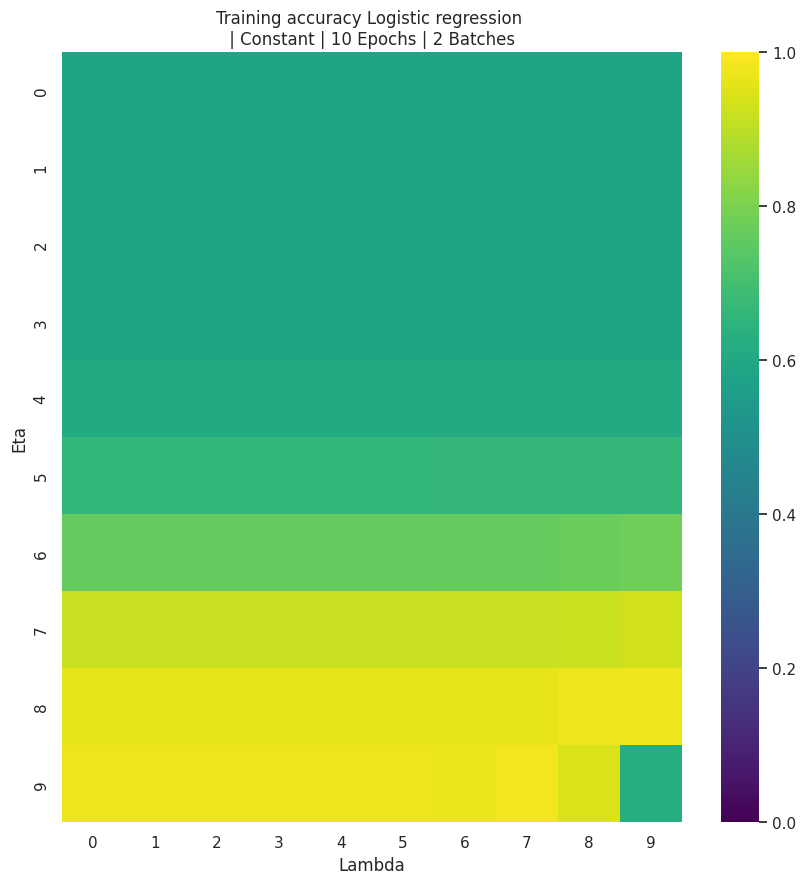

In [11]:
# logistic regression using ffnn
seed(42)
input_nodes = X_train.shape[1]
output_nodes = 1
dims = (input_nodes, output_nodes)
epochs = 10
batches = 2

# find best hyperparameters
sns.set()
eta_vals=np.logspace(-4, 1, 10)
lmbd_vals=np.logspace(-5, -1 , 10)
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        logistic_regression = FFNN(dimensions=dims, 
                                   output_func=sigmoid, cost_func=CostLogReg, seed=2023)
        logistic_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights
        scheduler = Constant(eta=eta)
        scores = logistic_regression.fit(X_train, t_train, scheduler=scheduler, 
                                         epochs=epochs, lam=lmbd, X_val=X_val, t_val=t_val)
        y_pred = logistic_regression.predict(X_val)
        accuracy = accuracy_score(t_val, y_pred)
        train_accuracy[i][j] = scores['train_accs'][-1]
        test_accuracy[i][j] = scores['val_accs'][-1]

# Plot test accuracy
fig1, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=False, ax=ax, cmap="viridis",vmin=0, vmax=1)
ax.set_ylabel("Eta")
ax.set_xlabel("Lambda")
ax.set_title(f"Test accuracy Logistic regression \n | Constant | {epochs} Epochs | {batches} Batches ")
plt.savefig('logistic_test.png')
# Plot train accuracy
fig1, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=False, ax=ax, cmap="viridis",vmin=0, vmax=1)
ax.set_ylabel("Eta")
ax.set_xlabel("Lambda")
ax.set_title(f"Training accuracy Logistic regression \n | Constant | {epochs} Epochs | {batches} Batches ")
plt.savefig('logistic_train.png')

best_accuracy = np.max(test_accuracy)
print(f'Best test accuracy: {best_accuracy}')

# Run with best hyperparameters to find predicted values
logistic_regression = FFNN(dimensions=dims, output_func=sigmoid, 
                           cost_func=CostLogReg,seed=2023)
logistic_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights
scheduler = Constant(eta=1)
scores = logistic_regression.fit(X_train, t_train, scheduler=scheduler, epochs=epochs,batches=batches, lam=0.1, X_val=X_val, t_val=t_val)
y_pred_log = logistic_regression.predict(X_val)
y_pred_log_train = logistic_regression.predict(X_train)
accuracy_log_train = scores['train_accs'][-1]
accuracy_log_test = scores['val_accs'][-1]

best_accuracy = np.max(test_accuracy)
print(f'Best test accuracy: {best_accuracy}')

In [12]:
np.reshape(test_accuracy,(len(eta_vals),-1))
print(test_accuracy.shape)
           
np.argmax(test_accuracy)


(10, 10)


97

## Plot confusion matrix


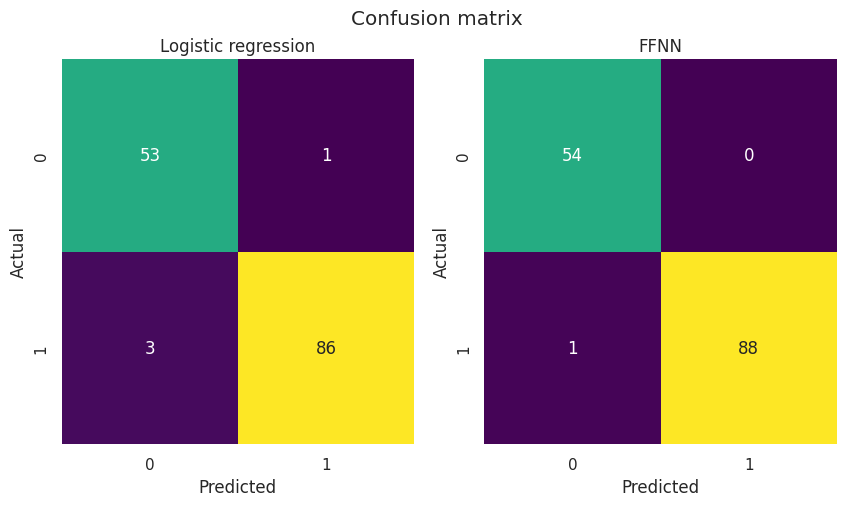

In [13]:
# Calculate the confusion matrix
cm_ffnn = confusion_matrix(t_val, y_pred_ffnn)
cm_log = confusion_matrix(t_val, y_pred_log)

# Create a heatmap to visualize the confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Confusion matrix')
log_reg=sns.heatmap(cm_log, annot=True, fmt="d", cmap="viridis", cbar=False, ax=ax1)
ffnn=sns.heatmap(cm_ffnn, annot=True, fmt="d", cmap="viridis", cbar=False, ax=ax2)
log_reg.set_xlabel("Predicted")
ffnn.set_xlabel('Predicted')
ffnn.set_ylabel("Actual")
log_reg.set_ylabel("Actual")
log_reg.set_xlabel('Predicted')
ax1.set_title('Logistic regression')
ax2.set_title('FFNN')
plt.savefig('results/ffnn_confusion_matrix.png')

## Plot ROC curve

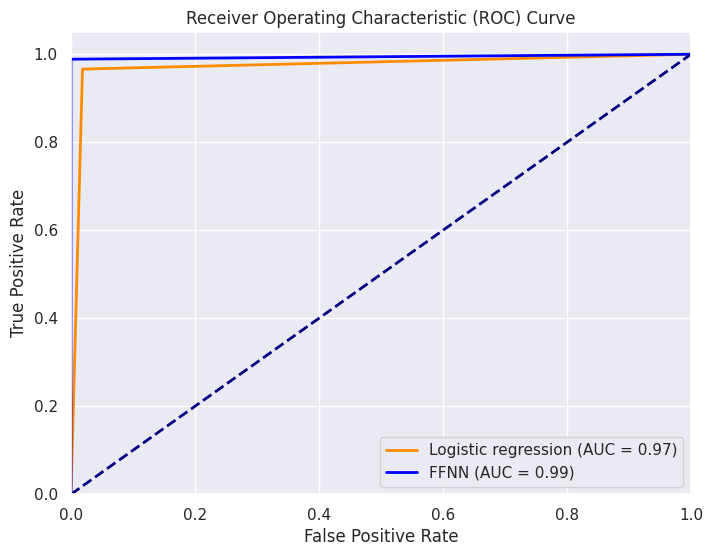

In [14]:
# ROC curve
fpr_log, tpr_log, thresholds = metrics.roc_curve(t_val, y_pred_log) # false positive rates, true positive rates
roc_auc_log = auc(fpr_log, tpr_log) # area under curve
fpr_ffnn, tpr_ffnn, thresholds = metrics.roc_curve(t_val, y_pred_ffnn) # false positive rates, true positive rates
roc_auc_ffnn = auc(fpr_ffnn, tpr_ffnn) # area under curve
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='darkorange', lw=2, label=f'Logistic regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_ffnn, tpr_ffnn, color='blue', lw=2, label=f'FFNN (AUC = {roc_auc_ffnn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('results/roc.png')
plt.show()

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score

pd.set_option('expand_frame_repr', False)

# Calculate precision, recall, and F1-score for logsitic reg
precision_log = precision_score(t_val, y_pred_log)
recall_log = recall_score(t_val, y_pred_log)
f1_log = f1_score(t_val, y_pred_log)

precision_log_train = precision_score(t_train, y_pred_log_train)
recall_log_train = recall_score(t_train, y_pred_log_train)
f1_log_train = f1_score(t_train, y_pred_log_train)

# Calculate precision, recall, and F1-score for ffnn
precision_ffnn = precision_score(t_val, y_pred_ffnn)
recall_ffnn = recall_score(t_val, y_pred_ffnn)
f1_ffnn = f1_score(t_val, y_pred_ffnn)

precision_ffnn_train = precision_score(t_train, y_pred_ffnn_train)
recall_ffnn_train = recall_score(t_train, y_pred_ffnn_train)
f1_ffnn_train = f1_score(t_train, y_pred_ffnn_train)

scores = {'Dataset': ['Train','','Test',''],
          '# Samples': [len(t_train),'',len(t_val),''],
          'Model': ['Logistic \n regression', 'FFNN','Logistic \nregression', 'FFNN'], 
          'Accuracy':[accuracy_log_train, accuracy_ffnn_train, accuracy_log_test, accuracy_ffnn_test],
          'Precision': [precision_log_train, precision_ffnn_train, precision_log,precision_ffnn], 
          'Recall': [recall_log_train, recall_ffnn_train, recall_log, recall_ffnn], 
          'F1 score': [f1_log_train, f1_ffnn_train, f1_log,f1_ffnn]}
pd.set_option('display.float_format', lambda x: '%.3f' % x)
score_table = pd.DataFrame(data=scores)
table = pretty_print(score_table)